In [ ]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2019-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [1]:
import nxsdk.api.n2a as nx
import numpy as np
import matplotlib.pyplot as plt
from nxsdk.utils.plotutils import plotRaster

net = nx.NxNet()

# Independent Networks in Same Run
This tutorial demonstrates that several independent and disconnected networks can be configured in the same run to take advantage of the available resources. In the sections below, three unrelated networks are created and run at the same time.     
## Setup the 1st network
In this network, two compartments are created with the same compartment prototype cxp. One compartment cxGrp[0] receives spike inputs injected by spikeGen, the other compartment fires with its own bias.

In [2]:
# create a compartment prototype
cxp = nx.CompartmentPrototype(biasMant=1000,
                               biasExp=6,
                               vThMant=10000,
                               compartmentVoltageDecay=0,
                               functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                               logicalCoreId=0)

# Create a compartmentGroup consisting of 2 compartments using prototype cxp 
cxGrp = net.createCompartmentGroup(size=2, prototype=cxp)

# add 3 spikes to spikeGen
numPorts = 1
spikeGen = net.createSpikeGenProcess(numPorts)
spikeTimes0 = [30, 40, 50]
spikeGen.addSpikes([0], [spikeTimes0])

# connect spikeGen with compartment 0 (cxGrp[0])
connProto = nx.ConnectionPrototype(weight=200, signMode=nx.SYNAPSE_SIGN_MODE.MIXED)
spikeGen.connect(cxGrp[0], prototype=connProto)

# set up voltage and spike probes for cxGrp
(vProbes, sProbes) = cxGrp.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE, nx.ProbeParameter.SPIKE])

## Setup the 2nd network
This network consists of three compartments: one source compartment cxSrc, and two destination compartments in the same group cxDst. cxSrc connects to the two destination compartments with different weight values. 

In [3]:
# create source compartment cxSrc
cxpSrc = nx.CompartmentPrototype(biasMant=100,
                                 biasExp=6,
                                 vThMant=1000,
                                 compartmentVoltageDecay=256,
                                 functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                                 logicalCoreId=0)
cxSrc = net.createCompartmentGroup(size=1, prototype=cxpSrc)

# create destination compartment group cxDst of size 2
cxpDst = nx.CompartmentPrototype(biasMant=0,
                                 vThMant=1000,
                                 compartmentCurrentDecay=256,
                                 compartmentVoltageDecay=256,
                                 functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                                 logicalCoreId=0)
cxDst = net.createCompartmentGroup(size=2, prototype=cxpDst)

# setup connection between cxSrc and csDst, with different values
connProto = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.MIXED)
conn = cxSrc.connect(cxDst,
                    prototype=connProto,
                    weight=np.array([[200], [100]]))

# set up probes for both cxSrc and cxDst
(cxSrcSProbe,) = cxSrc.probe([nx.ProbeParameter.SPIKE])
(cxDstUProbe,cxDstVProbe,cxDstSProbe) = cxDst.probe([nx.ProbeParameter.COMPARTMENT_CURRENT, 
                                                     nx.ProbeParameter.COMPARTMENT_VOLTAGE, 
                                                     nx.ProbeParameter.SPIKE])

## Setup the 3rd network
This network consists of 200 compartments, with each on its own neuro core. Except for the coreID, all compartments have the same configuration. Since there is only 128 cores in each chip, this network expands to 2 chips. All compartments are firing  based on bias, no connections are used here.

In [4]:
numCores = 200
cxList = []

# create one comparment in each core 
for coreId in range(0, numCores):
    # create compartment prototype
    pbasic = nx.CompartmentPrototype(biasMant=100,
                                     biasExp=6,
                                     vThMant=1000,
                                     compartmentCurrentDecay=410,
                                     compartmentVoltageDecay=256,
                                     functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                                     logicalCoreId=coreId)
    # add compartment in the list
    cxList.append(net.createCompartment(pbasic))

# setup probes for the last compartment in the list
cx = cxList[numCores-1]
(cxVProbe, cxSProbe) = cx.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE, nx.ProbeParameter.SPIKE])

In [5]:
net.run(80)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.80:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.10s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.02s)
INFO:DRV:      Executing... Done (0.08s)
INFO:DRV:      Processing timeSeries... Done (0.02s)
INFO:DRV:  N2Driver: Finished (0.23s)


## Results for the 1st network

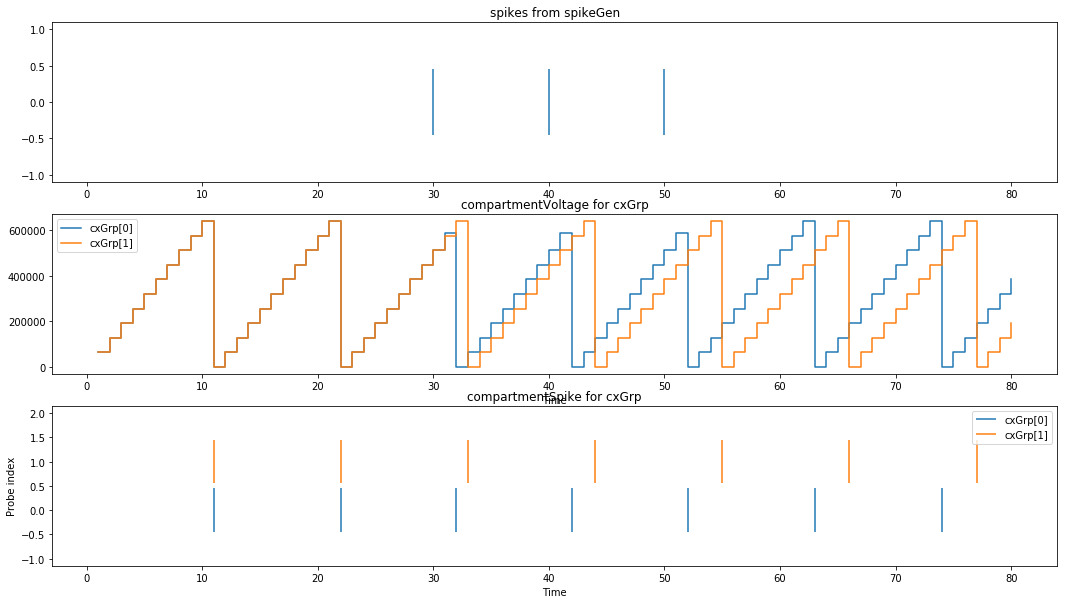

In [6]:
plt.figure(1, figsize=(18,10))
# Plot compartmentVoltage for cxGrp
ax2 = plt.subplot(3,1,2)
vh = vProbes.plot()
ax2.legend(['cxGrp[0]', 'cxGrp[1]'])
plt.title('compartmentVoltage for cxGrp')

# Plot compartmentSpike for cxGrp
ax3 = plt.subplot(3,1,3)
sProbes.plot(colors=[vh[0].get_color(), vh[1].get_color()])
ax3.set_xlim(ax2.get_xlim())
ax3.legend(['cxGrp[0]', 'cxGrp[1]'])
plt.title('compartmentSpike for cxGrp')

# plot spikes from spikeGen
ax1 = plt.subplot(3,1,1)
plotRaster([spikeTimes0])
ax1.set_xlim(ax2.get_xlim())
plt.title('spikes from spikeGen')
plt.show()
# spikeGen connects with cxGrp[0], providing additional stimulus to cxGrp[0] which fires earlier than
# cxGrp[1] after receving the spikes from spikGen.

## Results for the 2nd network

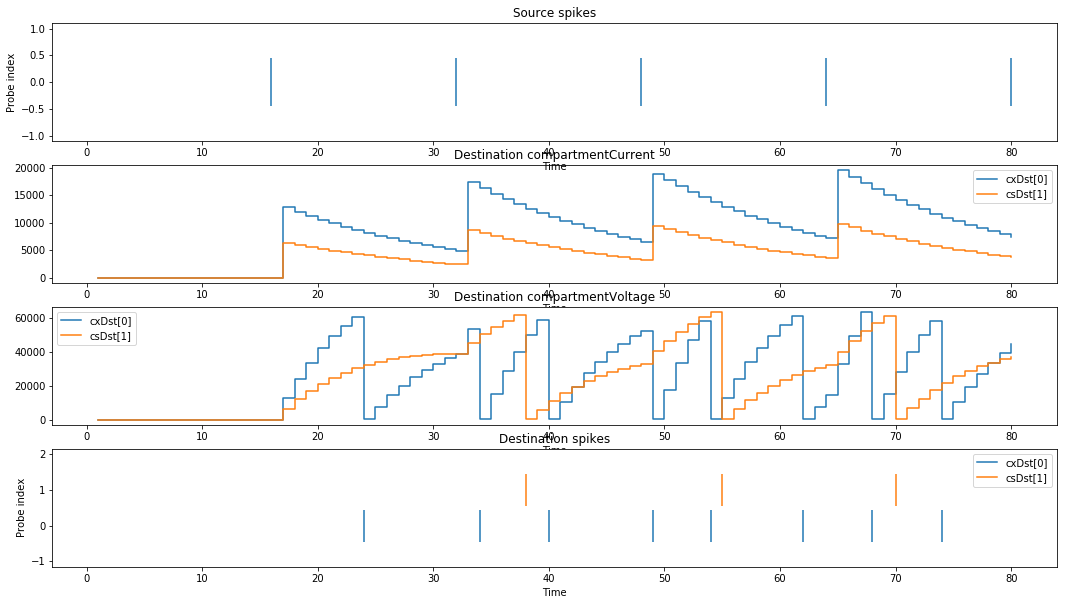

In [7]:
plt.figure(2, figsize=(18, 10))
# plot compartmentCurrent for csDst
ax2 = plt.subplot(4, 1, 2)
uh = cxDstUProbe.plot()
ax2.legend(uh, ['cxDst[0]', 'csDst[1]'])
plt.title('Destination compartmentCurrent')

# plot compartmentVoltage for csDst
ax3 = plt.subplot(4, 1, 3)
cxDstVProbe.plot()
ax3.legend(uh, ['cxDst[0]', 'csDst[1]'])
plt.title('Destination compartmentVoltage')

# plot compartmentSpike for csDst
ax4 = plt.subplot(4, 1, 4)
cxDstSProbe.plot(colors=[uh[0].get_color(), uh[1].get_color()])
ax4.set_xlim(ax2.get_xlim())
ax4.legend(uh, ['cxDst[0]', 'csDst[1]'])
plt.title('Destination spikes')

# plot spikes for cxSrc
ax1 = plt.subplot(4, 1, 1)
cxSrcSProbe.plot()
ax1.set_xlim(ax2.get_xlim())
plt.title('Source spikes')
plt.show()
# cxDst[0] and cxDst[1] are connected to the same source compartment cxSrc, with different weights. As shown below,
# their currents, voltages and spikes behave differently.

## Results for the 3rd network

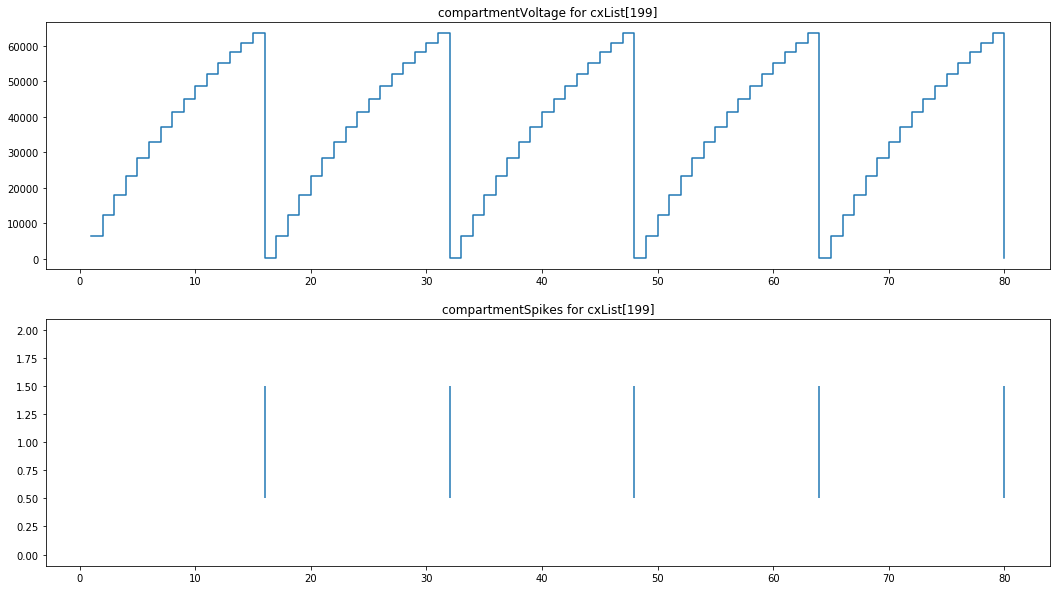

In [8]:
plt.figure(3, figsize=(18,10))
# plot compartmentVoltage for cxList[199]
ax0 = plt.subplot(2, 1, 1)
cxVProbe.plot()
plt.title('compartmentVoltage for cxList[199]')

# plot compartmentSpike for cxList[199]
ax1 = plt.subplot(2, 1, 2)
cxSProbe.plot()
ax1.set_xlim(ax0.get_xlim())
plt.title('compartmentSpikes for cxList[199]')
plt.show()
# Only the voltages and spikes for compartment cxList[199] are illustrated here. Except for coreID, all other compartments 
# in cxList have the same configuration.   

.. code-links:: python clear 